In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cleanlab datasets hdbscan matplotlib nltk sklearn torch tqdm transformers umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 73.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.7 MB/s eta 0:00:00

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from sentence_transformers import SentenceTransformer
import nltk
import numpy as np
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from seg_algorithm import get_optimal_splits, get_segmented_sentences
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import string
import cleanlab
from cleanlab.outlier import OutOfDistribution
url = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/corpus.csv"
dataset = pd.read_csv(url)
p = 0.65 #increase p = no of segments decreases

stop_words = set(stopwords.words('english'))
transcripts = dataset.transcripts
tokenized_transcripts = pd.DataFrame(index=range(44), columns=['Sentences'])

fullTranscripts = []
originalTranscript_list = [] # contains 44 transcripts
transcript_list = [] #contains 44 transcripts
filteredTranscript = []

# Creates a transcript list of set number of transcripts
for transcript in transcripts[0:1]:
    transcript = sent_tokenize(transcript)
    for sentence in transcript:
      fullTranscripts.append(sentence)

# Removes stop-words
for sentence in fullTranscripts:
    words = nltk.word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filteredTranscript.append(" ".join(filtered_words))

# Removes punctiation excluding ".", "!", "?"
exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")
filteredTranscript = [s.translate(str.maketrans('', '', exclude)) for s in filteredTranscript]

# Only includes sentences with number of words greater then set value
# Cuttoff number includes end punctuation as a word
filteredTranscript = [s for s in filteredTranscript if len(s.split())>4]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Fellow Citizens Senate House Representatives : Among vicissitudes incident life , event could filled greater anxieties notification transmitted order , received fourteenth day present month .', 'one hand , summoned Country , whose voice never hear veneration love , retreat chosen fondest predilection , , flattering hopes , immutable decision , asylum declining years : retreat rendered every day necessary well dear , addition habit inclination , frequent interruptions health gradual waste committed time .', 'hand , magnitude difficulty trust voice Country called , sufficient awaken wisest experienced citizens , distrustful scrutiny qualification , could overwhelm dispondence , one , , inheriting inferior endowments nature unpractised duties civil administration , ought peculiarly conscious deficencies .', 'conflict emotions , dare aver , , faithful study collect duty appreciation every circumstance , might affected .', 'dare hope , , , executing task much swayed grateful remembrance f

In [ ]:
# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')
embeddings = model.encode(filteredTranscript)

ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=embeddings)
top_train_outlier_idxs = (train_outlier_scores).argsort()[:15]
for x in top_train_outlier_idxs:
  filteredTranscript.pop(x)
print(filteredTranscript)
print(len(filteredTranscript))
print(top_train_outlier_idxs)

Fitting OOD estimator based on provided features ...
['Fellow Citizens Senate House Representatives  Among vicissitudes incident life  event could filled greater anxieties notification transmitted order  received fourteenth day present month .', 'one hand  summoned Country  whose voice never hear veneration love  retreat chosen fondest predilection   flattering hopes  immutable decision  asylum declining years  retreat rendered every day necessary well dear  addition habit inclination  frequent interruptions health gradual waste committed time .', 'hand  magnitude difficulty trust voice Country called  sufficient awaken wisest experienced citizens  distrustful scrutiny qualification  could overwhelm dispondence  one   inheriting inferior endowments nature unpractised duties civil administration  ought peculiarly conscious deficencies .', 'conflict emotions  dare aver   faithful study collect duty appreciation every circumstance  might affected .', 'dare hope    executing task much sway

In [ ]:
# Segmentation
segmentation  = get_optimal_splits(embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(filteredTranscript, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
# PrePCA Cosine Similarity Matrix
heatmap = np.zeros(shape=(len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    sent = embeddings[i]
    for j in range(len(embeddings)):
        sent2 = embeddings[j]
        cosSim = cos_similarity(sent, sent2)
        heatmap[i,j] = cosSim

In [ ]:
# PCA-95 Dimensionality Reduction
embedding = embeddings
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform(embedding)
print(reduced_embedding.shape)

(764, 221)


In [ ]:
# PostPCA Cosine Similarity Matrix (Sentence Similarity Matrix)
heatmapPost = np.zeros(shape=(len(reduced_embedding), len(reduced_embedding)))
for i in range(len(reduced_embedding)):
    sentPost = reduced_embedding[i]
    for j in range(len(reduced_embedding)):
        sent2Post = reduced_embedding[j]
        cosSimPost = cos_similarity(sentPost, sent2Post)
        heatmapPost[i,j] = cosSimPost

In [ ]:
# Remove Diagonal
# heatmapRD = np.delete(heatmap,range(0,heatmap.shape[0]**2,(heatmap.shape[0]+1))).reshape(heatmap.shape[0],(heatmap.shape[1]-1))

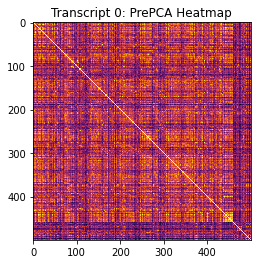

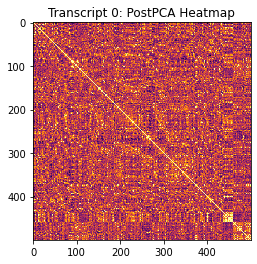

In [ ]:
# Prenormalized Heatmaps

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCA[i,j] = heatmap[i,j]
data = heatmapPrePCA
plt.imshow( data , cmap = 'inferno' , vmax = .7, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCA[i,j] = heatmapPost[i,j]
data = heatmapPostPCA
plt.imshow( data , cmap = 'inferno' , vmax = .35, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

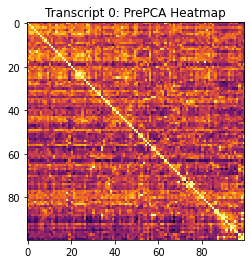

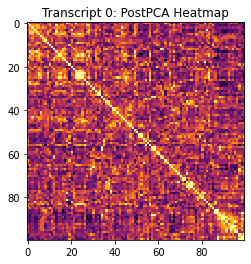

In [ ]:
# Standardize the Data

from sklearn.preprocessing import StandardScaler
heatmapStandard = StandardScaler().fit_transform(heatmap)
heatmapPostStandard = StandardScaler().fit_transform(heatmapPost)

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCAStandard[i,j] = heatmapStandard[i,j]
data = heatmapPrePCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCAStandard[i,j] = heatmapPostStandard[i,j]
data = heatmapPostPCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()


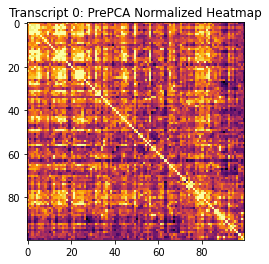

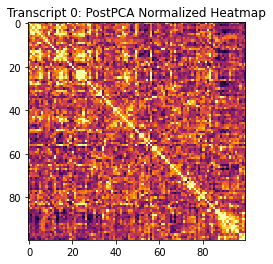

In [ ]:
# Normalized Heatmaps

# Normalize Pre and Post Cosine Similarity Matrixs
heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)
# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCANorm[i,j] = heatmapPreNorm[i,j]
data = heatmapPrePCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.6, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCANorm[i,j] = heatmapPostNorm[i,j]
data = heatmapPostPCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.5, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
plt.show()


In [ ]:
# Gets n max values
#Does NOT include the "1" in the row averages
heatmapnRows = len(heatmap)
nMax = 5
topnRowValues = np.zeros(shape=(heatmapnRows, nMax))
heatmapRowAverage = np.zeros(shape=(heatmapnRows, 1))
for i in range(heatmapnRows):
  ind = np.argpartition(heatmap[i,:], -nMax)[-nMax:]
  heatmapRowAverage[i] = (np.sum(heatmap[i,ind])-1)/(nMax-1)
  for j in range(5):
    topnRowValues[i,j] = heatmap[i,ind[j]]

print(topnRowValues[0])
print(heatmapRowAverage[0])

[0.522 0.545 0.557 0.56  1.   ]
[0.546]


In [ ]:
heatmapdf = pd.DataFrame(data=heatmap)
heatmapdf.to_csv('heatmap.csv')
heatmapPostdf = pd.DataFrame(data=heatmapPost)
heatmapPostdf.to_csv('reduced_heatmap_0.csv')
heatmapPrePCANormdf = pd.DataFrame(data=heatmapPreNorm)
heatmapPrePCANormdf.to_csv('heatmapPreNorm.csv')
heatmapPostPCANormdf = pd.DataFrame(data=heatmapPostNorm)
heatmapPostPCANormdf.to_csv('heatmapPostNorm.csv')

In [ ]:
# Test Code
# transcript_list = [] # contains 44 transcripts
# for transcript in transcripts[0:3]:    
#   transcript_list.append(sent_tokenize(transcript))

In [ ]:
# Test Code

# fullTranscripts = pd.DataFrame(fullTranscripts)
# fullTranscripts.to_csv('fullTranscripts.csv')

# embedding = pd.DataFrame(embedding)
# embedding.to_csv('embedding.csv')

# reduced_embedding = pd.DataFrame(reduced_embedding)
# reduced_embedding.to_csv('reduced_embedding.csv')

In [ ]:
# # Test Heatmaps

# # Normalize Pre and Post Cosine Similarity Matrixs
# heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
# heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
# heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
# heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)

# Zpositive = np.ma.masked_less(heatmapPreNorm, .3)
# Znegative = np.ma.masked_greater(heatmapPreNorm, .3)
# # PrePCA Heatmap
# x = 100
# y = 100
# heatmapPrePCAStand = np.zeros(shape=(y, x))
# for i in range(y):
#   for j in range(x):
#     heatmapPrePCAStand[i,j] = heatmapPreNorm[i,j]
# data = Zpositive
# plt.imshow( data , cmap = 'inferno', interpolation = 'nearest' )
# # color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
# plt.show()
# x = 100
# y = 100
# heatmapPrePCAStand = np.zeros(shape=(y, x))
# for i in range(y):
#   for j in range(x):
#     heatmapPrePCAStand[i,j] = heatmapPreNorm[i,j]
# data = Znegative
# plt.imshow( data , cmap = 'Blues', interpolation = 'nearest' )
# # color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
# plt.show()

# # PostPCA Heatmap
# x = 100
# y = 100
# heatmapPostPCAStand = np.zeros(shape=(y, x))
# for i in range(y):
#   for j in range(x):
#     heatmapPostPCAStand[i,j] = heatmapPostNorm[i,j]
# data = heatmapPostPCAStand
# plt.imshow( data , cmap = 'inferno' , vmin = -0.6, vmax = 0.8, interpolation = 'nearest' )
# # color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
# plt.show()